# Projecting the Number of Taxi Orders in the Next Hour for Sweet Lift Taxi Company

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Third-party imports - pmdarima
from pmdarima import auto_arima

# Third-party imports - statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic

# Third-party imports - scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
taxi_orders_df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
hourly_orders = taxi_orders_df.resample('1H').sum()
hourly_orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


C:\Users\Caitlin\AppData\Local\Temp\ipykernel_16132\3254929111.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_orders = taxi_orders_df.resample('1H').sum()


In [4]:
print(taxi_orders_df.info())
taxi_orders_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
del taxi_orders_df

In [6]:
hourly_orders.isna().sum()

num_orders    0
dtype: int64

<Axes: xlabel='datetime'>

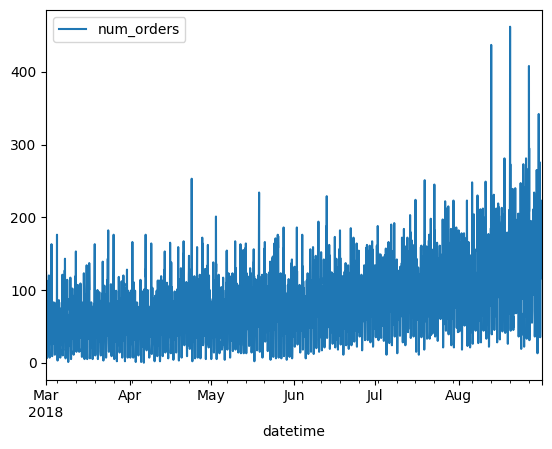

In [7]:
hourly_orders.plot()

In [8]:
result = adfuller(hourly_orders)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.0689242890279576
p-value: 0.028940051402612802


A p-value of .03 means that we can reject the null hypothesis that our data has a unit root (and therefore lacks stationarity). This means that no differencing is required. 

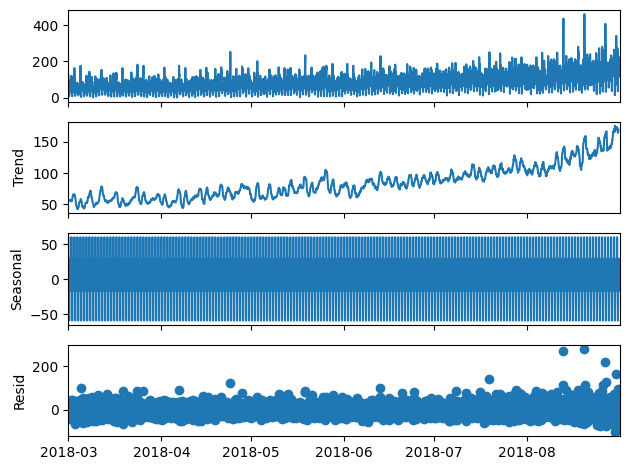

In [9]:
decomposition = seasonal_decompose(hourly_orders, model='additive', period=24)
fig = decomposition.plot()

Okay, our data exhibits a mild trend toward increased taxi use which likely results from increasingly nice weather. The the summetrical data with regular fluctions between periods suggests seasonality as well. Let's get a closer look to confirm. 

<Axes: title={'center': 'Two weeks of Orders'}, xlabel='datetime'>

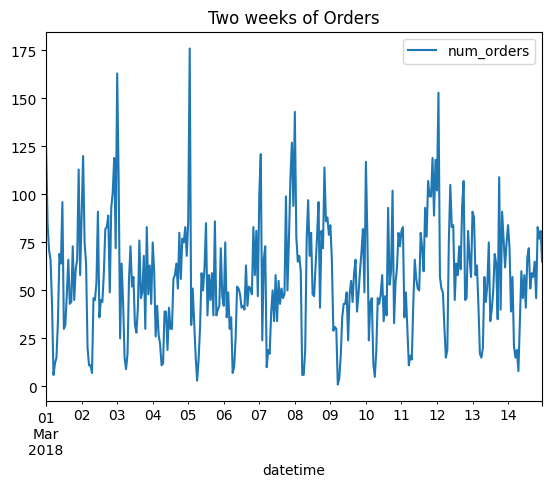

In [10]:
one_week = hourly_orders['2018-03-01': '2018-03-14']
one_week.plot(title='Two weeks of Orders')

As we suspected from our plot of the full data set, the above plot confirms that our data exhibits daily seasonality. It also suggests there may be some mild weekly seasonality (see for example 02-05 and 09-12). Therefore, we will add some lag features to pick up on these patterns. 

In [11]:
# Adding lag features to capture seasonality
hourly_orders['lag_1'] = hourly_orders['num_orders'].shift(1)
hourly_orders['lag_24'] = hourly_orders['num_orders'].shift(24)
hourly_orders['lag_168'] = hourly_orders['num_orders'].shift(168)

Given that there is daily and weekly seasonality, we might also expect that hour and dayofweek might be helpful here. Let's add those features as well. For good measure we'll also throw in day. 

In [ ]:
# Adding day of week and hour features
hourly_orders['hour'] = hourly_orders.index.hour
hourly_orders['day_of_week'] = hourly_orders.index.dayofweek
hourly_orders['day_of_month'] = hourly_orders.index.day

In [13]:
hourly_orders.isna().sum()

num_orders        0
lag_1             1
lag_24           24
lag_168         168
hour              0
day_of_week       0
day_of_month      0
dtype: int64

In [14]:
hourly_orders = hourly_orders.dropna()

In [15]:
# Split data set into test set and final training set
train_final, test = train_test_split(hourly_orders, shuffle=False, test_size=0.1)
# Split final training set into intial trianing and validation sets
train, val = train_test_split(train_final, shuffle=False, test_size=0.1)

# Create features and targets for all sets. 
final_features_train = train_final.drop('num_orders', axis=1)
final_target_train = train_final['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_val = val.drop('num_orders', axis=1)
target_val = val['num_orders']

Our first plot of the data showed daily seasonality, and since the unit of time we are interested in predicting value for is hours we will define one season as being 24 hours. 

KeyboardInterrupt: 

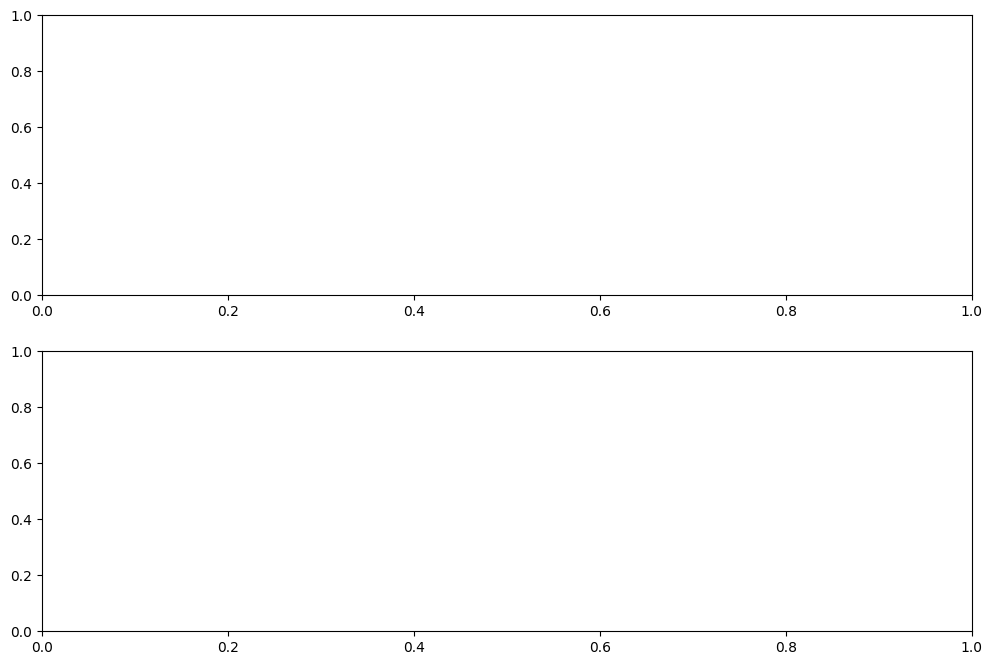

In [16]:
# Set s eqal to hours in a day
s = 24

# Plot PACF for up to 7 seasonal cycles (7 * s lags)
max_lag = 31 * s

fig, ax = plt.subplots(2, 1, figsize=(12,8))

# PACF plot
plot_pacf(target_train, lags=max_lag, ax=ax[0])
ax[0].set_title('Partial Autocorrelation Function (PACF)')

# ACF plot (useful for seasonal MA terms)
plot_acf(target_train, lags=max_lag, ax=ax[1])
ax[1].set_title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()

In [ ]:
%%time
model = auto_arima(
    target_train,
    seasonal=True,
    m=24,  # seasonal period (e.g., 24 for daily seasonality in hourly data)
    start_p=0, max_p=7,
    start_q=0, max_q=7,
    start_P=0, max_P=7,
    start_Q=0, max_Q=7,
    d=1, D=0,  # Fixed differencing orders
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # Set to False for full grid search (slower)
    information_criterion='aic'
)


print("Selected non-seasonal order (p,d,q):", model.order)
print("Selected seasonal order (P,D,Qm):", model.seasonal_order)

## Analysis

Our graph showed us that the hourly taxi orders from March through August appeared to be stationary. We were able to confirm this by running an adfuller() test that returned a p-value of 0.03.

Despite the stationarity, we can see from the seasonal_dcompose() plots that our data has significant seasonality. We engineered some new features which made intuitive sense given the type of data we are working with (taxi orders). That is we added lag_1, lag_24, and lag_168. lag_1 is standard practice, and lag_24 and lag_168 capture exactly the kind of cyclical patterns we might expect out of taxi orders. That is, we are using the corresponding hour from the previous day and the previous week to help predict the upcoming hour. We also added hour, dayofweek. 

Moreover, we can see from our PACF plot that these were good choices. It is also worth noting that our PACF plot suggests 6 multiples of the period size for the P value in our SARIMA model, and the ACF plot suggets even larger values than that for the Q value of our SARIMA function. 

Our arma_order_select_ic() analysis also reccomended the max_ar, and max_ma values for p and q in the ARMA portion of our SARIMA model. Howeer, for p, q, P, and Q, we will keep the values low for the sake of training time. 

## Training

### Linear Regression

In [ ]:
%%time
# Define model
model_lin = LinearRegression()
# Fit model
model_lin.fit(features_train, target_train)

### Sarima

In [ ]:
%%time
# Define model
model_sarima = sm.tsa.SARIMAX(
    target_train,
    order=(7, 1, 0),
    seasonal_order=(1, 0, 0, 24),
    trend='n',
    enforce_stationarity=True,
    enforce_invertibility=True
)

# Fit model
results = model_sarima.fit(disp=True)

### Sarima with smaller hyperparameter values

In [ ]:
%%time
# Define model
model_sarima_small = sm.tsa.SARIMAX(
    target_train,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 24),
    trend='n',
    enforce_stationarity=True,
    enforce_invertibility=True
)

# Fit model
results_small = model_sarima_small.fit(disp=True)

## Validating

In [ ]:
%%time 
# Validate model_lin
pred = model_lin.predict(features_val)

In [ ]:
%%time
# Number of steps to forecast
n_steps = len(target_val)

# Validate model_sarima
forecast_values = results.forecast(steps=n_steps)

In [ ]:
%%time
# Validate model_sarima_small
forecast_small = results_small.forecast(steps=n_steps)

In [ ]:
# Define a function to calculate RMSE for each model
def accuracy(
    y_true: pd.Series, y_pred: pd.Series, model: str) -> tuple[str, float]:
    # MSE method
    mse = mean_squared_error(y_true, y_pred)
    # Take square root of MSE
    rmse = np.sqrt(mse)
    # Return RMSE and model name
    return model, rmse
    

In [ ]:
accuracy(pred, target_val, 'model_lin')

In [ ]:
accuracy(forecast_values, target_val, 'model_sarima')

In [ ]:
accuracy(forecast_small, target_val, 'model_sarima_small')

## Testing

In [ ]:
# Test model_lin on final_train
model_lin.fit(final_features_train, final_target_train)

# Make predictions on test set
final_pred = model_lin.predict(features_test)

In [ ]:
accuracy(final_pred, target_test, 'model_lin')

Let's sanity check these results by comparing them to the predictions of a model that simply predicts the previous value of the target variable every time. 

In [ ]:
# Establish baseline by making predictions equivalent to the previous value
naive_pred = target_test.shift(1)

# Set first value in predictions equal to last value in training set (so we don't 
# have to have q less value in our naive model's test set due to shift(1))
initial_value = final_target_train.iloc[-1]
naive_pred.iloc[0] = initial_value

# Calculate RMSE for naive model
mse_naive = mean_squared_error(target_test, naive_pred)
np.sqrt(mse_naive)

As you can see our linear regression model has a little more than half the RMSE as the naive model. This is a good finding. However, it is possible that both models are simply inaccurate and our linear regression model is simply outperforming a bad model. Let's check the range and variance of our data set to get a sense for how well our model is actually performing, practically speaking. 

In [ ]:
# calculate variance of the target value
variance = target_test.var()
# Calcualte standard deviation of the target value
std = np.sqrt(variance)
# Find the max of the distribution
maximum = target_test.max()
# Find the minimum of the distribution
minimum = target_test.min()

# Print all of these parameters. 
print(f"Max: {maximum}")
print(f"Min: {minimum}\n")
print(f"Standard Deviation: {std}")

As you can see, the highest value in our target variable distribution is 462, and the lowest value is 13. More importantly, the standard deviation for our target variable distribution is 58.96. Therefore, our RMSE is a little more than half the standard deviation of the target variable, which means that in general are model predict the num_orders value for the next hour within a half a standard deviation (I can say this because RMSE is always greater than or equal to mean absolute error (MAE) which means the average error will actually be less than 35.80 orders off the mark). 

In conclusion, we tested three models:two SARIMA models with different hyperparameter values and one linear regression model. For the linear regression model we were able to engineer lag features that reflected the data's seasonality. The performance of the linear regeression (RMSE: 31.65) model was narrowly better than that of our two SARIMA models (RMSE: 32.32 for each). When we trained the linear regression model on the full trianing set and tested it, it came out with an RMSE of 35.80 This error is a little over half that of our naive model and easily meets the RMSE accuracy standard of 48 given to us by Sweet Lift Taxi Company. Therefore, we can confidently reccomend our linear regression model for their usage. 